In [3]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")
signal, fs =torchaudio.load('/media/prad/data/datasets/ChildSpeechDataset/child_speech_16_khz/0303_F_CT/0303_F_CTs2T01.wav')
embeddings = classifier.encode_batch(signal)

/home/prad/anaconda3/envs/diffwave/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")
signal, fs =torchaudio.load('/media/prad/data/datasets/ChildSpeechDataset/child_speech_16_khz/0303_F_CT/0303_F_CTs2T01.wav')
embeddings = classifier.encode_batch(signal)

In [1]:
import copy
import pandas as pd
import numpy as np
import tqdm
import os
from phoneme_info import phone2type_dict_base
from helper_fns import get_all_filetype_in_dir, textgridpath_to_phonedf, get_transcript_from_tgfile
from child_dataset_info import get_matching_tg_for_file
from helper_fns import process_silences
from pathlib import Path

In [2]:
from helper_fns import collapse_repeated_phones
def process_repeats(inp_df):
    tgdf = copy.deepcopy(inp_df)
    ''' flag silences in the middle of a word with nan'''
    for ii in range(len(tgdf)):
        if ii < len(tgdf) - 1 and ii > 0:
            # print(tgdf[phonekey][ii])
            if tgdf['phone'][ii] == tgdf['phone'][ii+1]:
                current_end_time = tgdf['end'].iloc[ii]
                next_start_time = tgdf['start'].iloc[ii + 1]
                next_end_time = tgdf['end'].iloc[ii + 1]
                if abs(current_end_time - next_start_time)<.001:
                    tgdf['end'][ii] = next_end_time
                    tgdf.at[ii+1, 'phone'] = np.nan
    ''' remove the silences'''
    # tgdf = tgdf[~pd.isna(tgdf[phonekey])].reset_index(drop=True).drop(columns=['index'])
    tgdf = tgdf[~pd.isna(tgdf['phone'])].reset_index(drop=True)
    ''' collapse the repeated phonemes '''
    return collapse_repeated_phones(tgdf, phonekey='phone')


In [3]:
manualtgpath = '/media/prad/data/datasets/ChildSpeechDataset/manually-aligned-text-grids'
tg_files_path = '/home/prad/github/charsiu/phone_matched_xvec_proj_processed'
tgs_xv = get_all_filetype_in_dir(tg_files_path, '.TextGrid') 
tgs_man = [filepath.replace('/home/prad/github/charsiu/phone_matched_xvec_proj_processed', '/media/prad/data/datasets/ChildSpeechDataset/manually-aligned-text-grids')
           for filepath in tqdm.tqdm(tgs_xv)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3762/3762 [00:00<00:00, 2357885.78it/s]


In [4]:
from praatio import textgrid
def word2textgrid(duration_seq,word_seq,save_path=None):
    """
    Save duration values to textgrids

    Parameters
    ----------
    duration_seq : list
        xxxxx A list of duration values.
    save_path : str, optional
        The path to save the TextGrid files. The default is None.

    Returns
    -------
    tg : TextGrid file?? str?? xxxxx?
        A textgrid object containing duration information.

    """

    tg = textgrid.Textgrid()
    phoneTier = textgrid.IntervalTier('phones', duration_seq, 0, duration_seq[-1][1])
    tg.addTier(phoneTier)
    wordTier = textgrid.IntervalTier('words', word_seq, 0, word_seq[-1][1])
    tg.addTier(wordTier)
    if save_path:
        tg.save(save_path,format="short_textgrid", includeBlankSpaces=False)
    return tg

In [5]:
tgs_xvnew = []
for tgpath in tqdm.tqdm(tgs_xv):
    transcript = get_transcript_from_tgfile(tgpath)
    tgout = process_silences(textgridpath_to_phonedf(tgpath, phone_key='phones', remove_numbers=True), transcript)
    out = [tuple(row) for row in tgout.values if 'sil' not in row[-1].lower() and 'unk' not in row[-1].lower()]
    tg = textgrid.Textgrid()
    phoneTier = textgrid.IntervalTier('phones', out, 0, out[-1][1])
    tg.addTier(phoneTier)
    
    outpath = tgpath.replace('/home/prad/github/charsiu/phone_matched_xvec_proj_processed', '/home/prad/github/DNN-PLLR/phone_matched_xvec_proj_processed')
    tgs_xvnew.append(outpath)
    os.makedirs(str(Path(outpath).parent), exist_ok=True)    
    tg.save(outpath, format='short_textgrid', includeBlankSpaces=False)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3762/3762 [00:08<00:00, 430.90it/s]


In [6]:
tgout = process_silences(textgridpath_to_phonedf(tgpath, phone_key='ha phones', remove_numbers=True), transcript)


KeyError: 'ha phones'

In [7]:
tgs_mannew = []
for tgpath in tqdm.tqdm(tgs_man):
    transcript = get_transcript_from_tgfile(tgpath)
    tgout = process_silences(textgridpath_to_phonedf(tgpath, phone_key='ha phones', remove_numbers=True), transcript)
    out = []
    
    for row in tgout.values:
        if 'sil' not in row[-1].lower() and 'unk' not in row[-1].lower():
            if 'BIH' in row[-1]:
                print(row)
            row[-1] = row[-1].replace('BIH', 'B')
            row[-1] = row[-1].replace('VV', 'V')
            row[-1] = row[-1].replace('H', 'HH') if row[-1]=='H' else row[-1]
            row[-1] = row[-1].replace('I', 'IH') if row[-1]=='I' else row[-1]
            out.append(tuple(row))
    # print(out)
    # out = [tuple(row) for row in tgout.values if 'sil' not in row[-1].lower() and 'unk' not in row[-1].lower()]
    
    tg = textgrid.Textgrid()
    phoneTier = textgrid.IntervalTier('phones', out, 0, out[-1][1])
    tg.addTier(phoneTier)
    
    outpath = tgpath.replace('/media/prad/data/datasets/ChildSpeechDataset/manually-aligned-text-grids/', '/home/prad/github/DNN-PLLR/manual_textgrids_postprocessed/')
    tgs_mannew.append(outpath)
    os.makedirs(str(Path(outpath).parent), exist_ok=True)    
    tg.save(outpath, format='short_textgrid', includeBlankSpaces=False)


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                 | 1781/3762 [00:04<00:05, 393.61it/s]

[1.388556191688984 1.4427908519560655 'BIH']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3762/3762 [00:09<00:00, 393.78it/s]


In [8]:
textgridpath_to_phonedf(tgs_mannew[0], phone_key='phones', remove_numbers=True)

,start,end,phone
0,0.362614,0.580000,D
1,0.580000,0.958831,IY


In [9]:
cnt = 0
idxs = []
for ii, (man, est) in enumerate(tqdm.tqdm(zip(tgs_man, tgs_xvnew))):
    mantg = textgridpath_to_phonedf(man, phone_key='ha phones', remove_numbers=True)
    esttg = textgridpath_to_phonedf(est, phone_key='phones', remove_numbers=True)
    mantg = process_repeats(mantg[mantg['phone']!='[SIL]'].reset_index(drop=True))
    esttg = esttg[esttg['phone']!='[SIL]']
    if len(mantg)!=len(esttg):
        cnt+=1
        idxs.append(ii)

31it [00:00, 309.49it/s]/home/prad/anaconda3/envs/dnngop/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
3762it [00:11, 341.20it/s]


# Phonewise Analysis

In [1]:
import copy
import pandas as pd
import numpy as np
import tqdm
import os
from phoneme_info import phone2type_dict_base
from helper_fns import get_all_filetype_in_dir, textgridpath_to_phonedf, get_transcript_from_tgfile
from child_dataset_info import get_matching_tg_for_file
from helper_fns import process_silences
from pathlib import Path

In [2]:
tg_files_path = '/home/prad/github/charsiu/phone_matched_xvec_proj_processed'
tgs_xv = get_all_filetype_in_dir(tg_files_path, '.TextGrid') 
tgs_manproc = [filepath.replace('/home/prad/github/charsiu/phone_matched_xvec_proj_processed', '/home/prad/github/DNN-PLLR/manual_textgrids_postprocessed')
           for filepath in tqdm.tqdm(tgs_xv)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3762/3762 [00:00<00:00, 2201307.43it/s]


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [4]:
#We use the processed versions of both to avoid any artifacts in the comparisons
W2V_PATH =   './pllr_dfs_new/pllr_phonewise_xvec_w2vmodel_PROCESSED.csv'
HAND_PATH = './pllr_dfs_new/pllr_phonewise_handalign_w2vmodel_PROCESSED.csv'

xdfp = pd.read_csv(W2V_PATH).drop(columns=['Unnamed: 0'])
hdfp = pd.read_csv(HAND_PATH).drop(columns=['Unnamed: 0'])

In [5]:
xdf = xdfp.groupby('Phone').mean()
hdf = hdfp.groupby('Phone').mean()
diffdf = xdf - hdf

diffdf = diffdf.reset_index()
xdf = xdf.reset_index()
hdf = hdf.reset_index()

Text(0.5, 1.0, 'LLP_xVec - LLP_HandAlign')

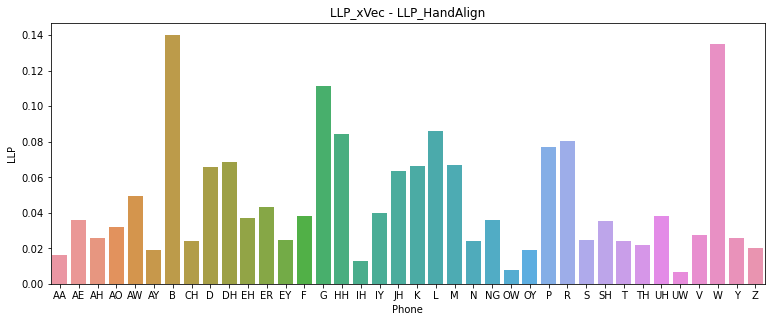

In [6]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(data=diffdf, x='Phone', y='LLP')
plt.title('LLP_xVec - LLP_HandAlign')

Text(0.5, 1.0, 'PLLR_xVec - PLLR_HandAlign')

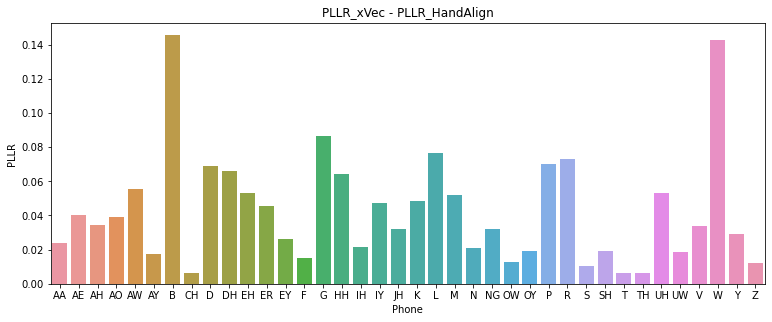

In [7]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(data=diffdf, x='Phone', y='PLLR')
plt.title('PLLR_xVec - PLLR_HandAlign')

Text(0.5, 1.0, 'Phone Length vs PLLR Difference')

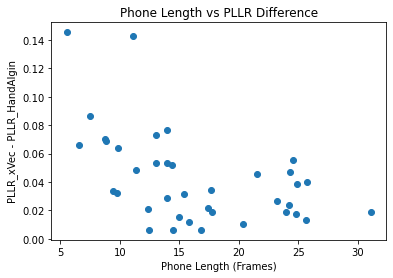

In [8]:
plt.figure()
plt.scatter(hdf.PhoneLenFrames, diffdf.PLLR)
plt.xlabel('Phone Length (Frames)')
plt.ylabel('PLLR_xVec - PLLR_HandAlgin')
plt.title('Phone Length vs PLLR Difference')

Text(0.5, 1.0, 'Phone Length vs PLLR Difference')

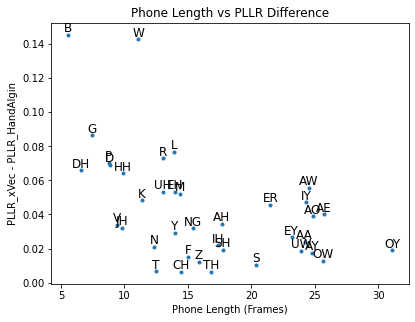

In [9]:
plt.figure(figsize=(6.4, 4.8))
plt.scatter(hdf.PhoneLenFrames, diffdf.PLLR, marker='.')
for i in range(len(hdf.PhoneLenFrames.values)):
    plt.text(hdf.PhoneLenFrames.values[i], diffdf.PLLR.values[i], f'{hdf.Phone[i]}', fontsize=12, ha='center', va='bottom')
plt.xlabel('Phone Length (Frames)')
plt.ylabel('PLLR_xVec - PLLR_HandAlgin')
plt.title('Phone Length vs PLLR Difference')

NameError: name 'x' is not defined

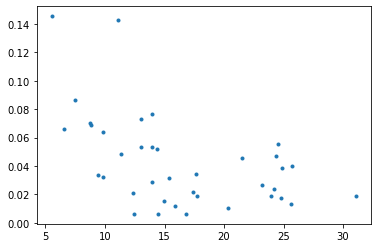

In [10]:
plt.figure()
plt.scatter(hdf.PhoneLenFrames, diffdf.PLLR, marker='.')
for i in range(len(x)):
    plt.text(hdf.PhoneLenFrames.values[i], diffdf.PLLR.values[i], f'Point {i+1}', fontsize=12, ha='center', va='bottom')
plt.xlabel('Phone Length (Frames)')
plt.ylabel('PLLR_xVec - PLLR_HandAlgin')
plt.title('Phone Length vs PLLR Difference')

<AxesSubplot:xlabel='LLP', ylabel='PLLR'>

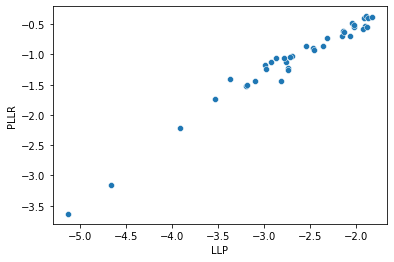

In [11]:
sns.scatterplot(data=xdf, x='LLP', y='PLLR')
# plt.plot([-5, -1], [-5, -1])

### Phonewise PLLR difference

In [12]:
intelig_df = pd.read_csv("./adjust-adjusted-intelligibility.csv")
intelig_df = intelig_df.rename(columns={'child':'Speaker'})
def calc_pllr_corr_one_df(INTELLIG_DF, DF2):
    
    pass

In [13]:
dfx = xdfp[xdfp['Phone']=='AA'].reset_index(drop=True)
dfh = hdfp[hdfp['Phone']=='AA'].reset_index(drop=True)

dfx = xdfp.copy()
dfh = hdfp.copy()
dfxspk = dfx.groupby('Speaker', as_index=False).mean().rename(columns={'PLLR':'PLLR_xvec', 'LLP':'LLP_xvec'})
dfhspk = dfh.groupby('Speaker', as_index=False).mean().rename(columns={'PLLR':'PLLR_hand', 'LLP':'LLP_hand'})

In [14]:
xdfp = xdfp.rename(columns={'PLLR':'PLLR_xvec', 'LLP':'LLP_xvec'}) 
hdfp = hdfp.rename(columns={'PLLR':'PLLR_hand', 'LLP':'LLP_hand'})
mdfp = hdfp.merge(xdfp, on=['Utterance', 'Phone', 'Speaker'], how='inner', suffixes=['_hand', '_xvec'])

In [15]:
# mdfp = pd.DataFrame.merge(, , how='inner')
mdfp['PLLR_diff'] = mdfp['PLLR_xvec'] - mdfp['PLLR_hand']
dfm = mdfp.groupby('Speaker', as_index=False).mean()

dfm['PLLR_diff'] = dfm['PLLR_xvec'] - dfm['PLLR_hand']
dfm = pd.DataFrame.merge(dfm, intelig_df, how='inner', on='Speaker')

Text(0.5, 1.0, 'Age vs [PLLR_xVec - PLLR_HandAlign]')

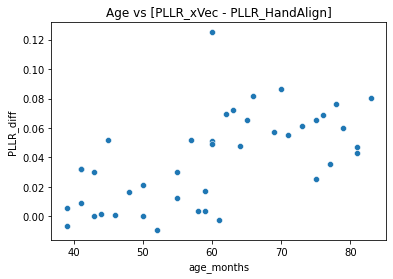

In [16]:
sns.scatterplot(dfm, x='age_months', y='PLLR_diff')
plt.title('Age vs [PLLR_xVec - PLLR_HandAlign]')

In [17]:
dfm.sort_values('PLLR_diff', ascending=False).reset_index(drop=True)[:10]

,Speaker,PLLR_hand,LLP_hand,PhoneLenFrames_hand,PLLR_xvec,LLP_xvec,PhoneLenFrames_xvec,PLLR_diff,age_months,n_items,mean_intelligibility,age_adjusted_intelligibility
0,0500_F_IG,-1.004832,-2.635311,18.215463,-0.879856,-2.508661,18.252218,0.124977,60,98,0.854847,0.051571
1,0510_M_BK,-0.953016,-2.498535,15.021546,-0.866552,-2.419954,14.389100,0.086464,70,97,0.848564,-0.017881
2,0506_F_LH,-1.008583,-2.652310,16.216389,-0.926996,-2.571526,15.897567,0.081587,66,97,0.870066,0.028889
3,0611_F_AP,-0.731292,-2.025545,13.263889,-0.650852,-1.946491,13.628788,0.080440,83,98,0.947643,-0.000921
4,0606_F_NS,-0.816198,-2.300350,14.304020,-0.739700,-2.225868,14.351759,0.076498,78,98,0.930770,0.013791
5,0503_M_SR,-0.937640,-2.453425,15.393443,-0.865705,-2.381935,15.160151,0.071935,63,98,0.902940,0.080713
6,0502_F_KM,-1.032022,-2.558344,15.509434,-0.962587,-2.491854,15.284277,0.069435,62,98,0.872024,0.056114
7,0604_F_CC,-0.752481,-2.150705,14.694058,-0.683951,-2.080154,14.874842,0.068530,76,97,0.917415,0.013069
8,0505_M_EK,-0.875933,-2.346082,17.426020,-0.810152,-2.278981,17.350765,0.065780,65,97,0.846527,0.011666
9,0603_M_LS,-0.734627,-2.047235,13.945501,-0.669110,-1.969930,14.134347,0.065518,75,98,0.924526,0.026497


In [18]:
biggest_discrepancy_speakers = dfm.sort_values('PLLR_diff', ascending=False).reset_index(drop=True)[:10].Speaker.values

In [19]:
from phoneme_info import ENGLISH_PHONEME_LIST, PHONEME_INFO_DF_BASIC, phone2type_dict_base
PHONEME_INFO_DF_BASIC = PHONEME_INFO_DF_BASIC[['phoneme', 'type']].rename(columns={'phoneme': 'Phone'})
mdfp = mdfp.drop(columns='type', errors='ignore')
mdfp = pd.merge(mdfp, PHONEME_INFO_DF_BASIC, on='Phone')
def phonewise_pllrdiff_plot(groupdf, groupname, xcolname):
    PHONEME_TYPES = PHONEME_INFO_DF_BASIC.type.unique()
    plt.figure(figsize=(6.4*2, 4.8))
    if xcolname=='Phone':
        _ord = ENGLISH_PHONEME_LIST
    elif xcolname=='type':
        _ord = PHONEME_TYPES
    sns.barplot(data=groupdf, x=xcolname, y='PLLR_diff', order=_ord)
    plt.ylabel('PLLR_xvec - PLLR_HandAlign')
    plt.ylim([-.2, .8])
    plt.title(f'PLLR_xVec - PLLR_HandAlign:\n{groupname}')    

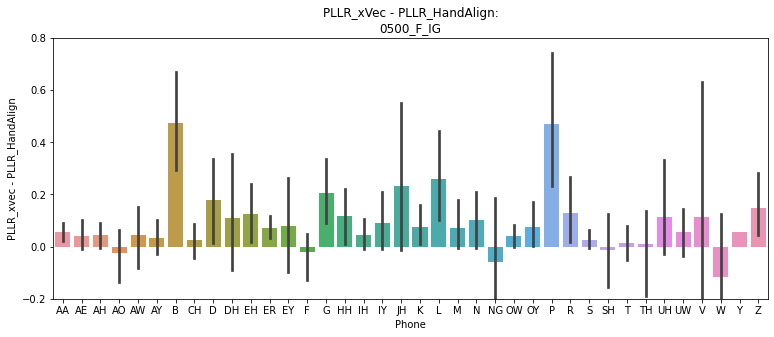

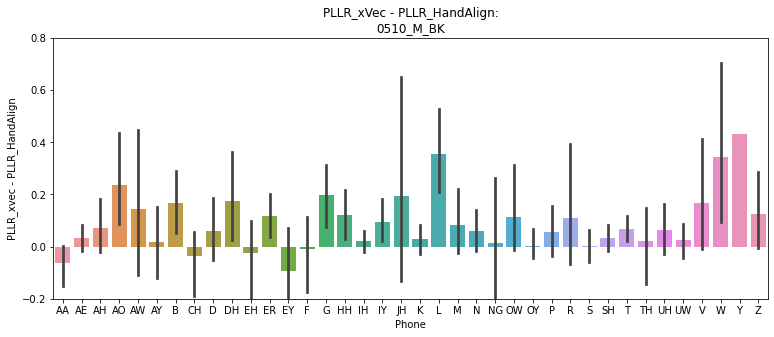

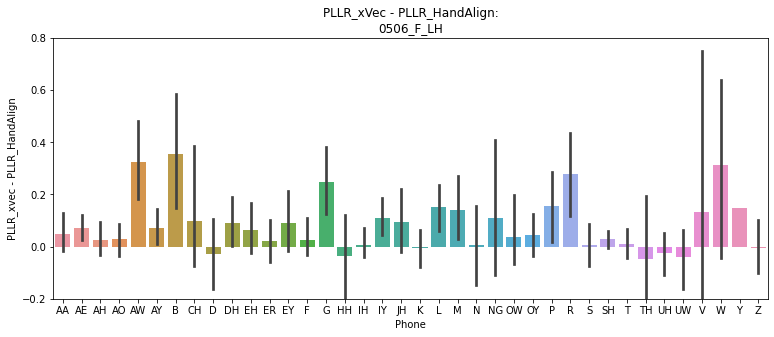

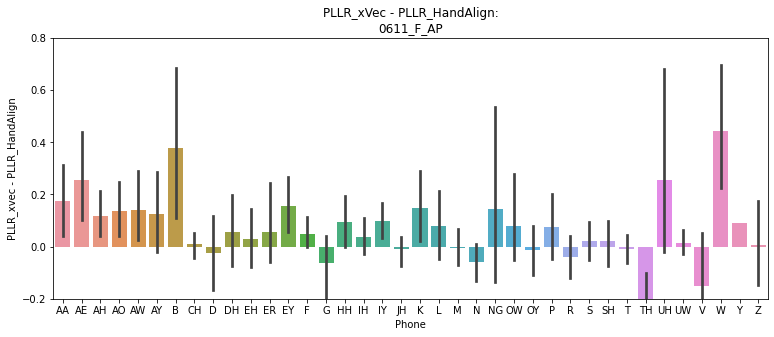

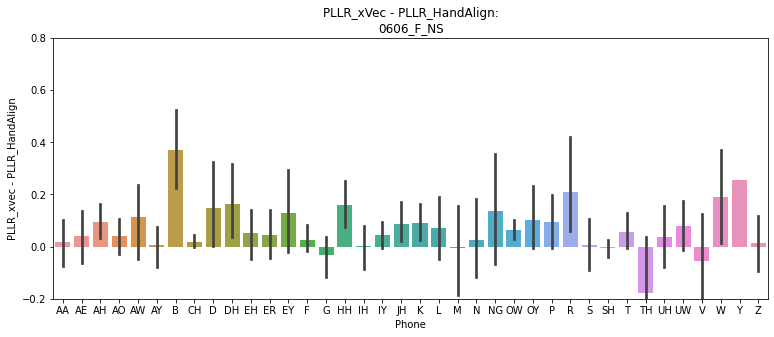

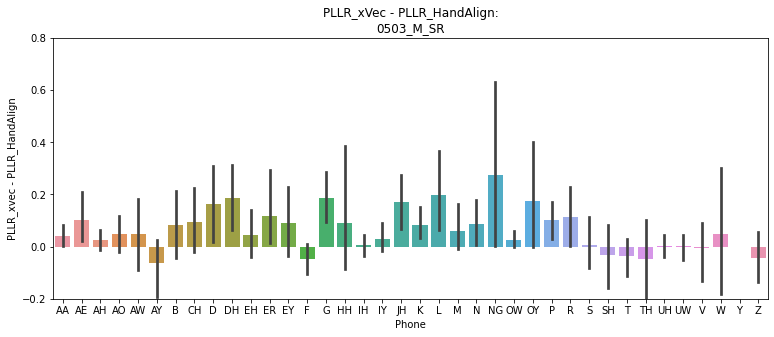

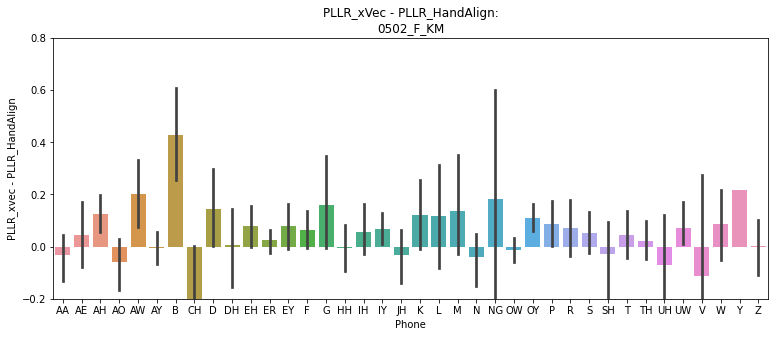

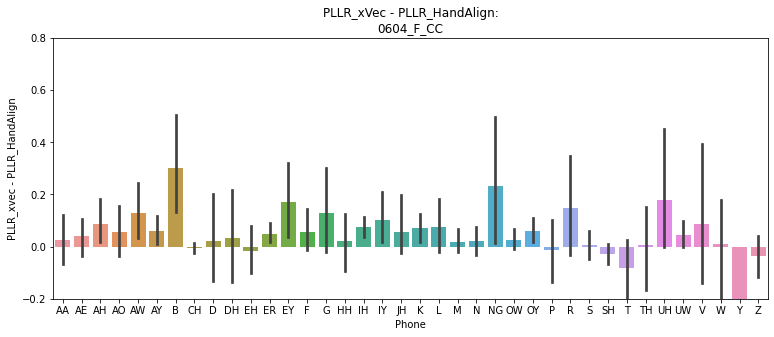

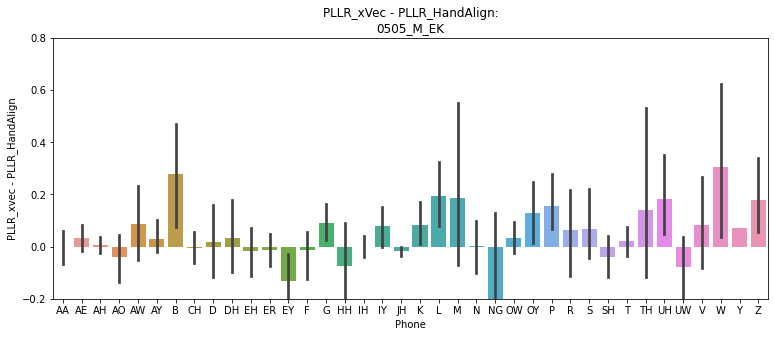

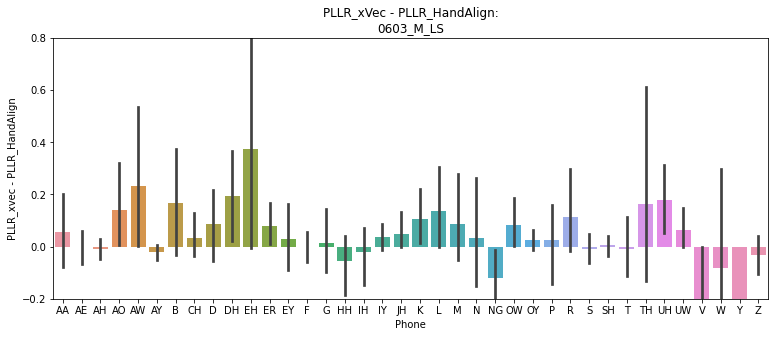

In [20]:
for spkr in biggest_discrepancy_speakers:
    sdf = mdfp[mdfp['Speaker']==spkr]
    phonewise_pllrdiff_plot(sdf, spkr, xcolname='Phone')

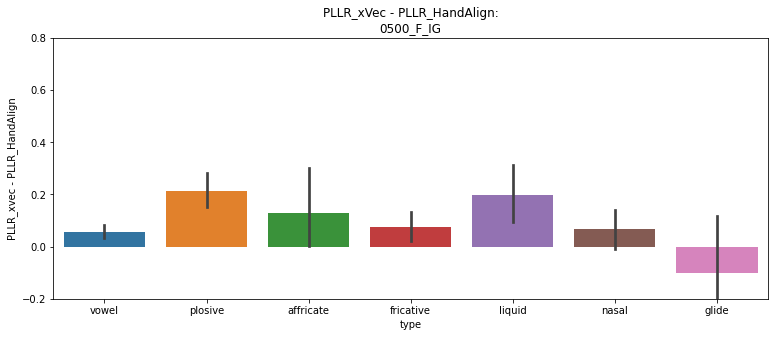

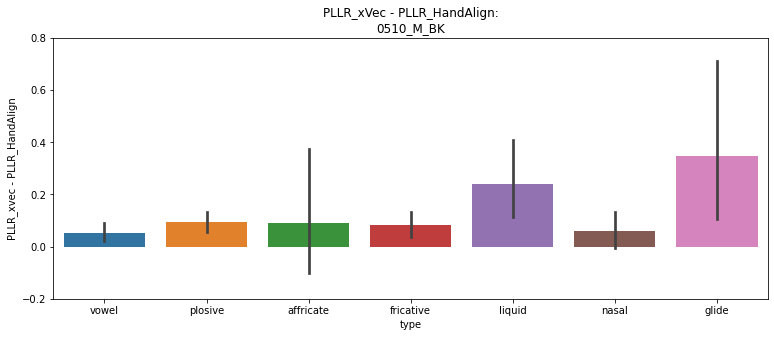

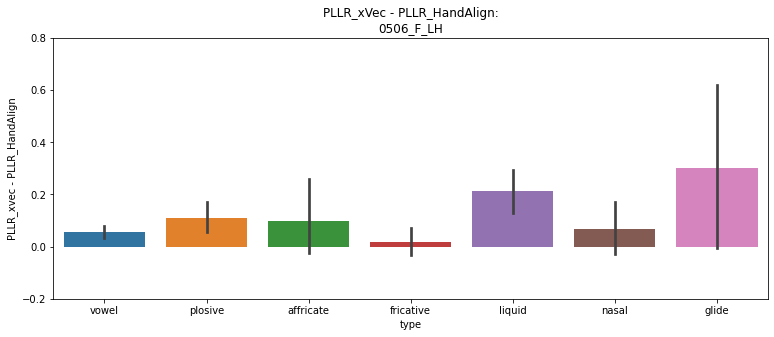

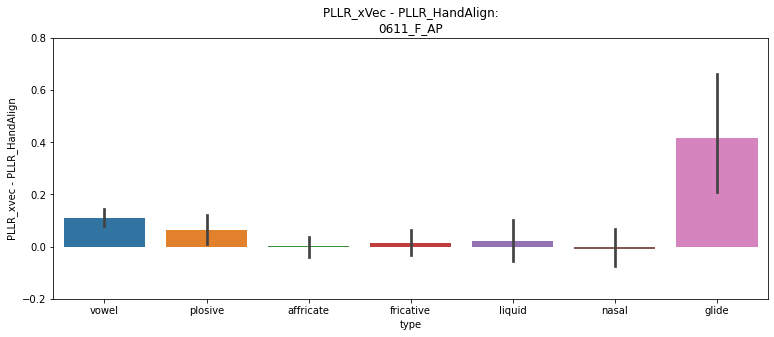

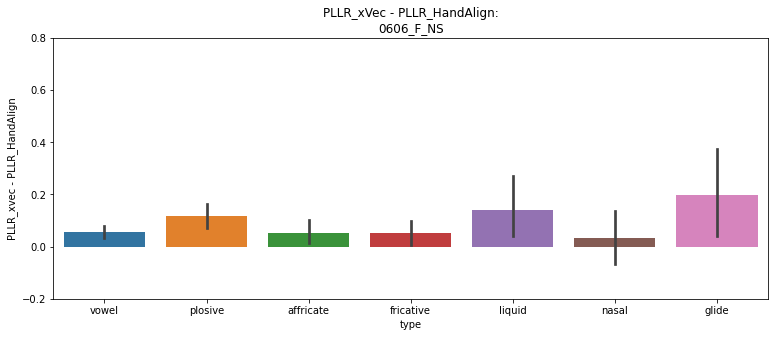

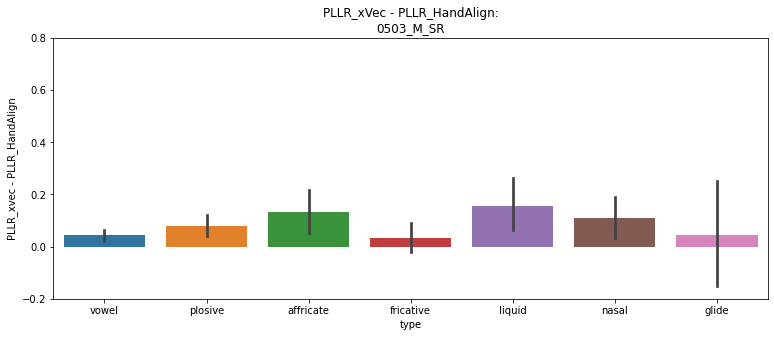

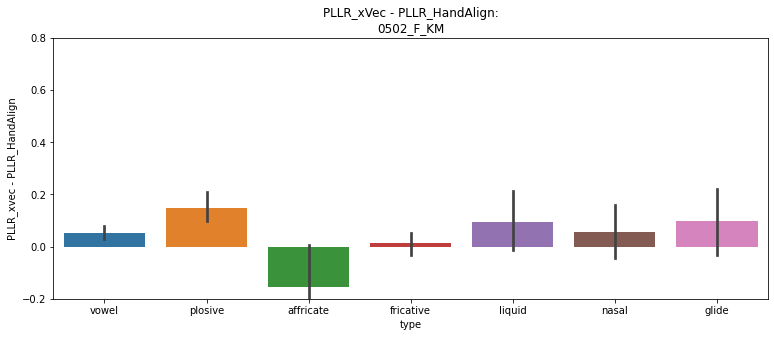

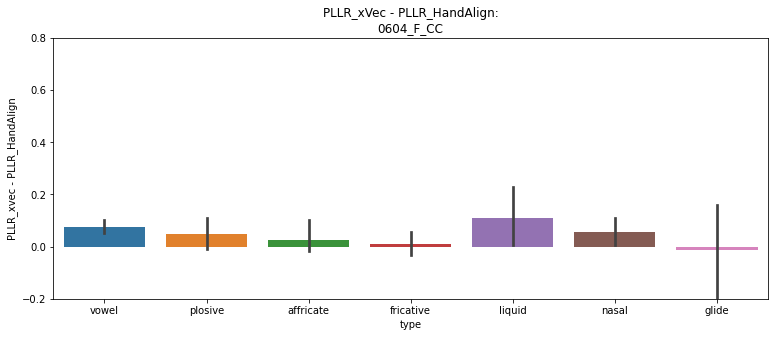

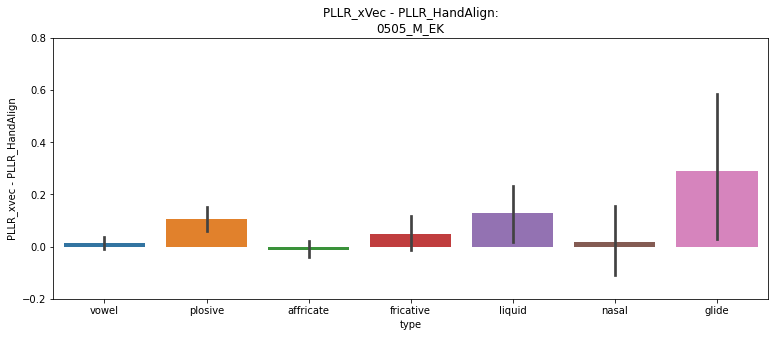

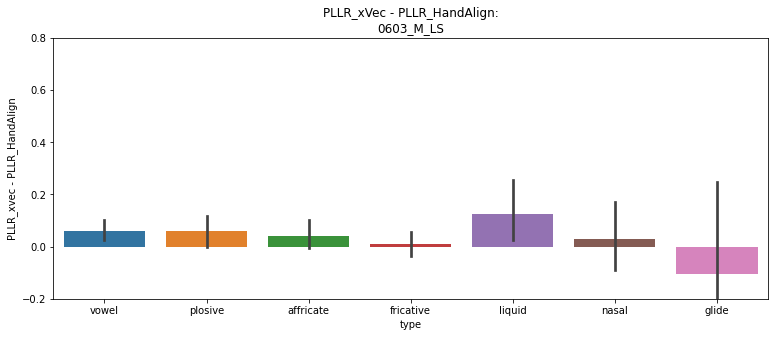

In [21]:
for spkr in biggest_discrepancy_speakers:
    sdf = mdfp[mdfp['Speaker']==spkr]
    phonewise_pllrdiff_plot(sdf, spkr, xcolname='type')

In [22]:
spkrtgs_man = [_tg for _tg in tgs_manproc if biggest_discrepancy_speakers[0] in _tg]
spkrtgs_xv = [_tg for _tg in tgs_xv if biggest_discrepancy_speakers[0] in _tg]

_idx = 6
print(spkrtgs_man[_idx])
textgridpath_to_phonedf(spkrtgs_man[_idx], phone_key='phones', remove_numbers=True).round(3)

/home/prad/github/DNN-PLLR/manual_textgrids_postprocessed/0500_F_IG/0500_F_IGwT20.TextGrid


,start,end,phone
0,0.436,0.64,Z
1,0.640,1.11,UW


In [23]:
textgridpath_to_phonedf(spkrtgs_xv[_idx], phone_key='phones', remove_numbers=True)

,start,end,phone
0,0.00,0.43,[SIL]
1,0.43,0.63,Z
2,0.63,1.06,UW
3,1.06,1.45,[SIL]


### Phonewise Correlation Difference

In [24]:
mdfp = pd.merge(mdfp, intelig_df, on='Speaker')

In [25]:
mdfp.shape


(28637, 15)

In [26]:
asdf = mdfp[mdfp['Phone']=='HH']

In [27]:
asdf.columns

Index(['Speaker', 'Utterance', 'Phone', 'PLLR_hand', 'LLP_hand',
       'PhoneLenFrames_hand', 'PLLR_xvec', 'LLP_xvec', 'PhoneLenFrames_xvec',
       'PLLR_diff', 'type', 'age_months', 'n_items', 'mean_intelligibility',
       'age_adjusted_intelligibility'],
      dtype='object')

In [28]:
from pllr_utils.pllr_analysis_fns import compute_age_adj_pllr

def corrfn(group, age_col='age_months'):
    _type = group.type.values[0]
    group =  group.groupby('Speaker').agg(lambda x: x.mean(skipna=True))
    corrdf = group.corr()
    pllrcor = corrdf['PLLR_xvec']['PLLR_hand']
    xvagecor = corrdf['PLLR_xvec']['age_months']
    handagecor = corrdf['PLLR_hand']['age_months']
    xvecintelcor = corrdf['PLLR_xvec']['mean_intelligibility']
    xvecintelcor_age = corrdf['PLLR_xvec']['age_adjusted_intelligibility']
    handintelcor = corrdf['PLLR_hand']['mean_intelligibility']
    handintelcor_age = corrdf['PLLR_hand']['age_adjusted_intelligibility']
    from sklearn.linear_model import LinearRegression
    cols = [col for col in group.columns if 'PLLR' in col]
    outdct = {'PLLR_xvec_Age_Corr': xvagecor, 'PLLR_hand_Age_Corr': handagecor,  
                      'PLLR_xvec': group['PLLR_xvec'].mean(), 
                      'PLLR_hand': group['PLLR_hand'].mean(),
                      'PLLR_xvec_intel_Corr':xvecintelcor,
                      'PLLR_xvec_intel_Corr_AgeAdj':xvecintelcor_age,
                      'PLLR_hand_intel_Corr':handintelcor, 
                      'PLLR_hand_intel_Corr_AgeAdj':handintelcor_age, 
                      'PLLR_corr':pllrcor,
                      'PhoneLenFrames_hand':group['PhoneLenFrames_hand'].mean(),
                      'PhoneLenFrames_xvec':group['PhoneLenFrames_xvec'].mean(),
                      'PhoneLenFrames_diff':np.mean(group['PhoneLenFrames_xvec'] - group['PhoneLenFrames_hand']),
                      'type':_type,
                      'age_adjusted_intelligibility':group['age_adjusted_intelligibility'].mean(), 
                      'mean_intelligibility':group['mean_intelligibility'].mean(), 
                      'PLLR_diff': group['PLLR_xvec'].mean() - group['PLLR_hand'].mean(),}
    for ii, col in enumerate(cols):
        ages = group[age_col].values.reshape(-1, 1)
        age_adj_col = group[col].values.reshape(-1, 1)
        keepids = ~pd.isna(age_adj_col)
        # print('----')
        # print(len(age_adj_col))
        # print(sum(keepids))
        ages = ages[keepids].reshape(-1, 1)
        age_adj_col = age_adj_col[keepids]
        lm = LinearRegression()
        try:
            lm.fit(ages, age_adj_col)
            # lm.fit(ages[keepids], age_adj_col[keepids])
            
        except:
            print('ERROR')
            # break
        resid = age_adj_col.ravel() - lm.predict(ages).ravel()
        aaintel = group['age_adjusted_intelligibility'].values[keepids.ravel()]
        # print(age_adj_col.shape)
        # print(lm.predict(ages).shape)
        outdct[f'AgeAdj{col}_AgeAdjIntellig_Corr'] = np.corrcoef(resid.astype('float').ravel(), aaintel)[0, 1]
        
        outdct[f'AgeAdj{col}_AgeAdjIntellig_Corr'] = np.corrcoef(resid.astype('float').ravel(), aaintel)[0, 1]
    return pd.Series(outdct)

tmp = mdfp.groupby('Phone').apply(corrfn).reset_index()
tmp['Age_Corrdiff'] = tmp['PLLR_xvec_Age_Corr'] - tmp['PLLR_hand_Age_Corr']
tmp['Intellig_Corrdiff'] = tmp['PLLR_xvec_intel_Corr'] - tmp['PLLR_hand_intel_Corr']
tmp['Corrdif_PLLR_AgeAdjIntellig'] = tmp['PLLR_xvec_intel_Corr_AgeAdj'] - tmp['PLLR_hand_intel_Corr_AgeAdj']
tmp['Corrdif_AgeAdjPLLR_AgeAdjIntellig'] = tmp['AgeAdjPLLR_xvec_AgeAdjIntellig_Corr'] - tmp['AgeAdjPLLR_hand_AgeAdjIntellig_Corr']

/home/prad/anaconda3/envs/dnngop/lib/python3.7/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
/home/prad/anaconda3/envs/dnngop/lib/python3.7/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
/home/prad/anaconda3/envs/dnngop/lib/python3.7/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the a

Text(0.5, 1.0, 'Correlation Difference \n Corr(PLLR_Xvec, Intellig) - Corr(PLLR_Hand, Intellig)')

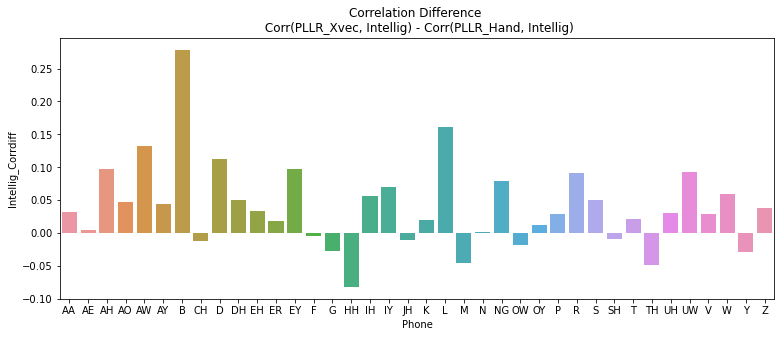

In [29]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='Intellig_Corrdiff', order=ENGLISH_PHONEME_LIST)
plt.title('Correlation Difference \n Corr(PLLR_Xvec, Intellig) - Corr(PLLR_Hand, Intellig)')

In [30]:
len(_df)

NameError: name '_df' is not defined

Text(0, 0.5, 'Corr(PLLR_xVec, PLLR_hand)')

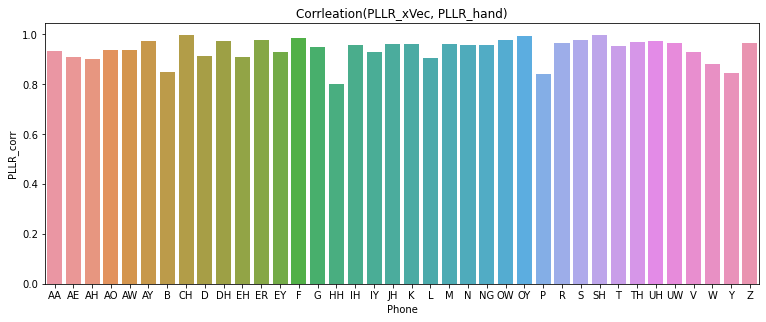

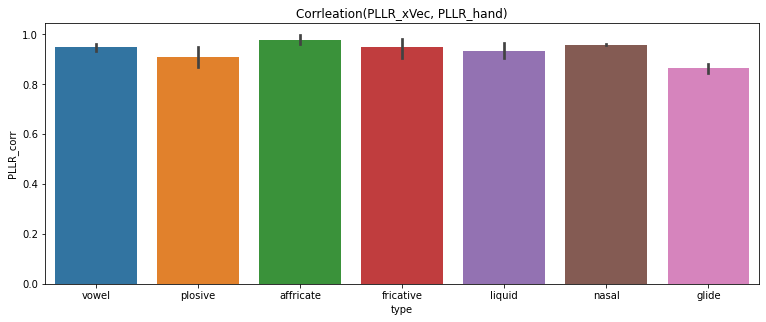

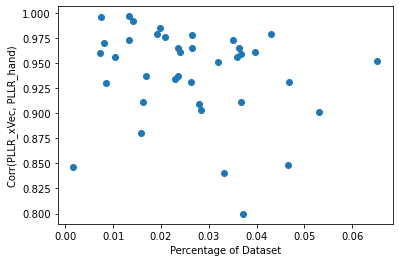

In [31]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='PLLR_corr', order=ENGLISH_PHONEME_LIST)
plt.title('Corrleation(PLLR_xVec, PLLR_hand)')

plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='type', y='PLLR_corr')
plt.title('Corrleation(PLLR_xVec, PLLR_hand)')

plt.figure()
pcts = [len(_df)/len(mdfp) for (phn, _df) in mdfp.groupby('Phone')]
plt.scatter(pcts, tmp.PLLR_corr)
plt.xlabel('Percentage of Dataset')
plt.ylabel('Corr(PLLR_xVec, PLLR_hand)')

Text(0.5, 1.0, 'Correlation Difference \n Corr(PLLR_Xvec, AgeAdjIntellig) - Corr(PLLR_Hand, AgeAdjIntellig)')

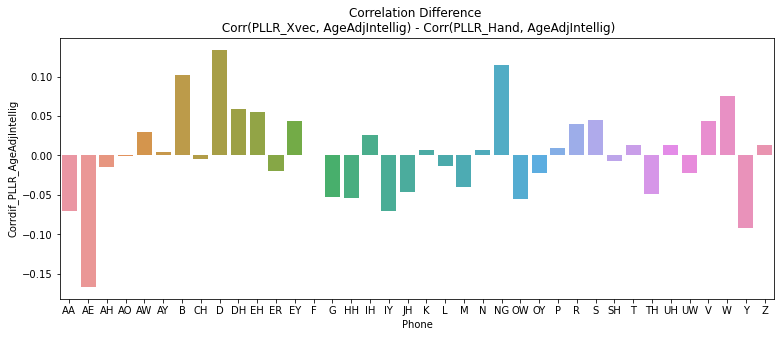

In [34]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='Corrdif_PLLR_AgeAdjIntellig', order=ENGLISH_PHONEME_LIST)
plt.title('Correlation Difference \n Corr(PLLR_Xvec, AgeAdjIntellig) - Corr(PLLR_Hand, AgeAdjIntellig)')

Text(0.5, 1.0, 'Correlation Difference \n Corr(PLLR_Xvec, AgeAdjIntellig) - Corr(PLLR_Hand, AgeAdjIntellig)')

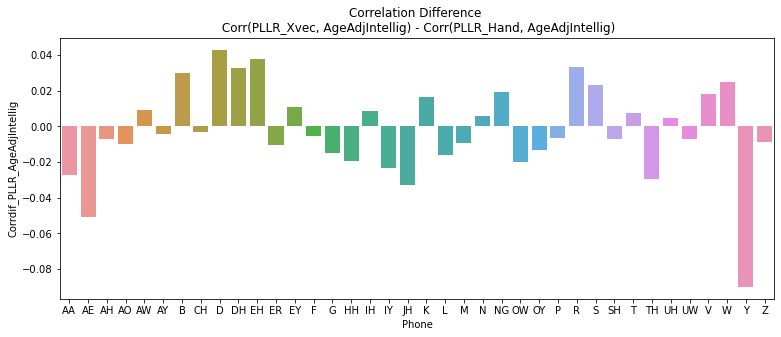

In [38]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='Corrdif_PLLR_AgeAdjIntellig', order=ENGLISH_PHONEME_LIST)
plt.title('Correlation Difference \n Corr(PLLR_Xvec, AgeAdjIntellig) - Corr(PLLR_Hand, AgeAdjIntellig)')

In [42]:
tmp.columns

Index(['Phone', 'PLLR_xvec_Age_Corr', 'PLLR_hand_Age_Corr', 'PLLR_xvec',
       'PLLR_hand', 'PLLR_xvec_intel_Corr', 'PLLR_xvec_intel_Corr_AgeAdj',
       'PLLR_hand_intel_Corr', 'PLLR_hand_intel_Corr_AgeAdj',
       'PhoneLenFrames_hand', 'PhoneLenFrames_xvec', 'PhoneLenFrames_diff',
       'type', 'age_adjusted_intelligibility', 'mean_intelligibility',
       'PLLR_diff', 'AgeAdjPLLR_hand_AgeAdjIntellig_Corr',
       'AgeAdjPLLR_xvec_AgeAdjIntellig_Corr',
       'AgeAdjPLLR_diff_AgeAdjIntellig_Corr', 'Age_Corrdiff',
       'Intellig_Corrdiff', 'Corrdif_PLLR_AgeAdjIntellig',
       'Corrdif_AgeAdjPLLR_AgeAdjIntellig'],
      dtype='object')

Text(0.5, 1.0, 'Corr(PLLR_Xvec, Intellig)')

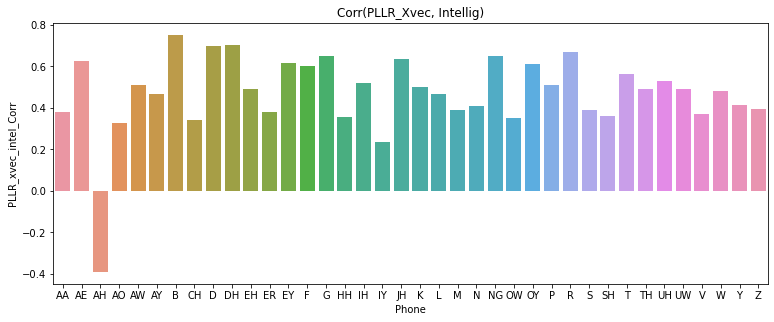

In [49]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='PLLR_xvec_intel_Corr', order=ENGLISH_PHONEME_LIST)
plt.title('Corr(PLLR_Xvec, Intellig)')

Text(0.5, 1.0, 'Corr(PLLR_Hand, AgeAdjIntellig)')

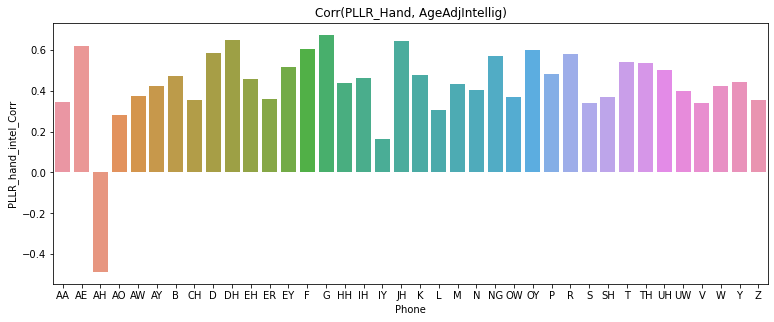

In [46]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='PLLR_hand_intel_Corr', order=ENGLISH_PHONEME_LIST)
plt.title('Corr(PLLR_Hand, AgeAdjIntellig)')

Text(0.5, 1.0, 'Corr(AgeAdjPLLR_xvec, AgeAdjIntellig)')

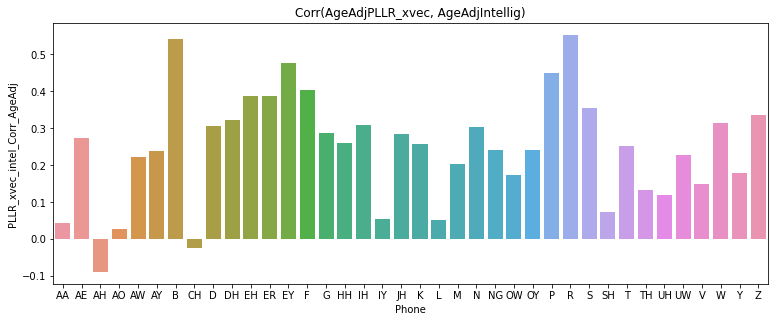

In [48]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='PLLR_xvec_intel_Corr_AgeAdj', order=ENGLISH_PHONEME_LIST)
plt.title('Corr(AgeAdjPLLR_xvec, AgeAdjIntellig)')

Text(0.5, 1.0, 'Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

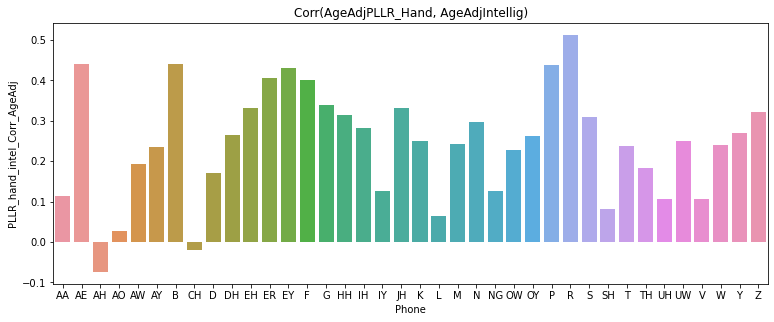

In [47]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='PLLR_hand_intel_Corr_AgeAdj', order=ENGLISH_PHONEME_LIST)
plt.title('Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

Text(0.5, 1.0, 'Correlation Difference \n Corr(AgeAdjPLLR_Xvec, AgeAdjIntellig) - Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

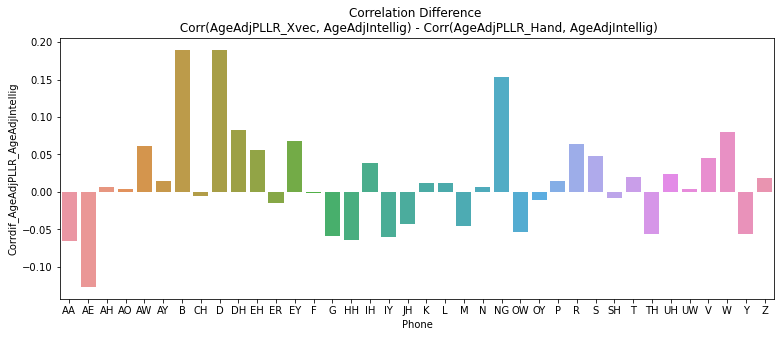

In [35]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='Corrdif_AgeAdjPLLR_AgeAdjIntellig', order=ENGLISH_PHONEME_LIST)
plt.title('Correlation Difference \n Corr(AgeAdjPLLR_Xvec, AgeAdjIntellig) - Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

Text(0.5, 1.0, 'Correlation Difference \n Corr(AgeAdjPLLR_Xvec, AgeAdjIntellig) - Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

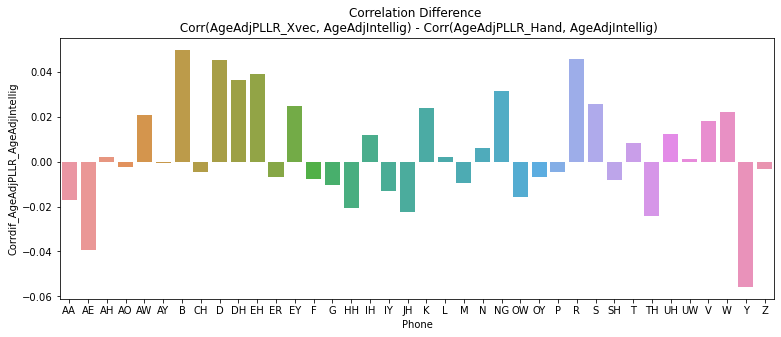

In [40]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='Corrdif_AgeAdjPLLR_AgeAdjIntellig', order=ENGLISH_PHONEME_LIST)
plt.title('Correlation Difference \n Corr(AgeAdjPLLR_Xvec, AgeAdjIntellig) - Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

Text(0.5, 1.0, 'Correlation Difference \n Corr(AgeAdjPLLR_Xvec, AgeAdjIntellig) - Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

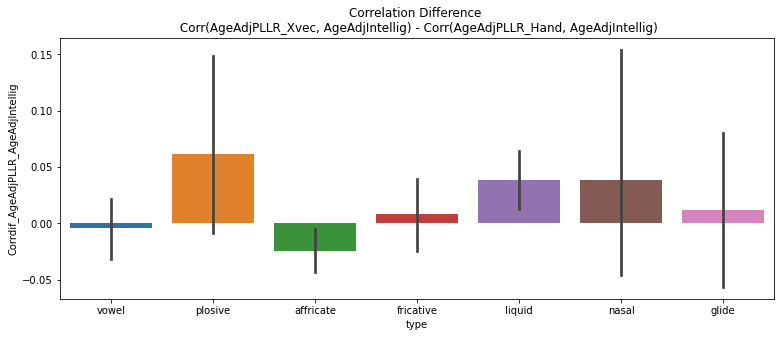

In [34]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='type', y='Corrdif_AgeAdjPLLR_AgeAdjIntellig')
plt.title('Correlation Difference \n Corr(AgeAdjPLLR_Xvec, AgeAdjIntellig) - Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

In [32]:
[col for col in tmp.columns if 'Corrdif' in col]

['Age_Corrdiff',
 'Intellig_Corrdiff',
 'Corrdif_PLLR_AgeAdjIntellig',
 'Corrdif_AgeAdjPLLR_AgeAdjIntellig']

Text(0.5, 1.0, 'Correlation Difference \n Corr(PLLR_Xvec, Intellig) - Corr(PLLR_Hand, Intellig)')

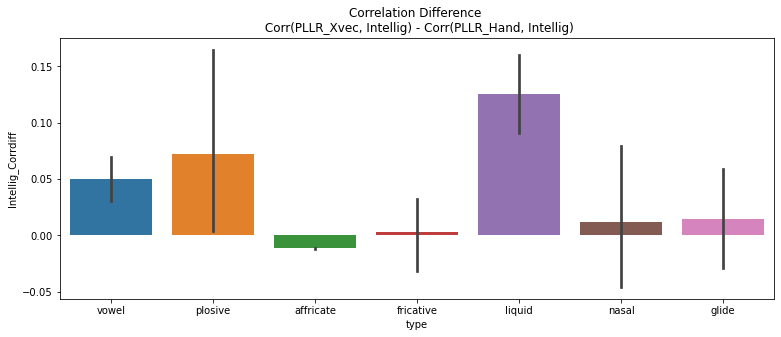

In [40]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='type', y='Intellig_Corrdiff')
plt.title('Correlation Difference \n Corr(PLLR_Xvec, Intellig) - Corr(PLLR_Hand, Intellig)')

Text(0.5, 1.0, 'Correlation Difference \n Corr(AgeAdjPLLR_Xvec, AgeAdjIntellig) - Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

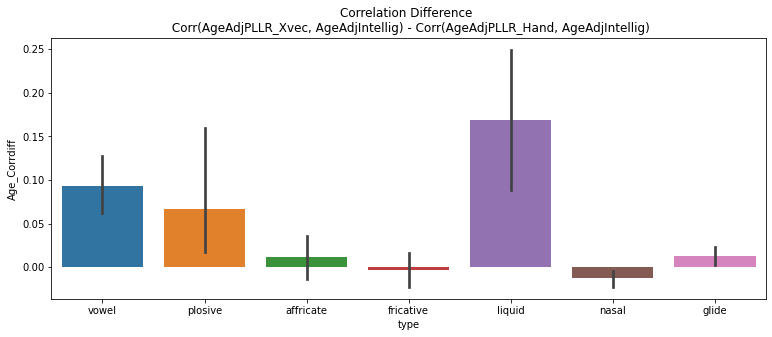

In [39]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='type', y='Age_Corrdiff')
plt.title('Correlation Difference \n Corr(AgeAdjPLLR_Xvec, AgeAdjIntellig) - Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

Text(0.5, 1.0, 'Correlation Difference \n Corr(PLLR_Xvec, AgeAdjIntellig) - Corr(PLLR_Hand, AgeAdjIntellig)')

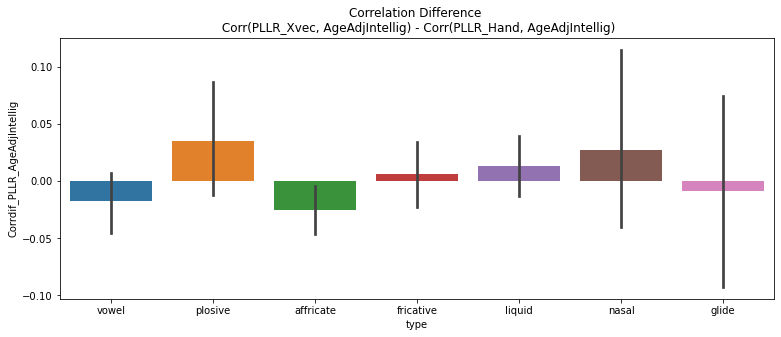

In [41]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='type', y='Corrdif_PLLR_AgeAdjIntellig')
plt.title('Correlation Difference \n Corr(PLLR_Xvec, AgeAdjIntellig) - Corr(PLLR_Hand, AgeAdjIntellig)')

# Phone Length Difference

Text(0.5, 1.0, 'Correlation Difference \n Corr(AgeAdjPLLR_Xvec, AgeAdjIntellig) - Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

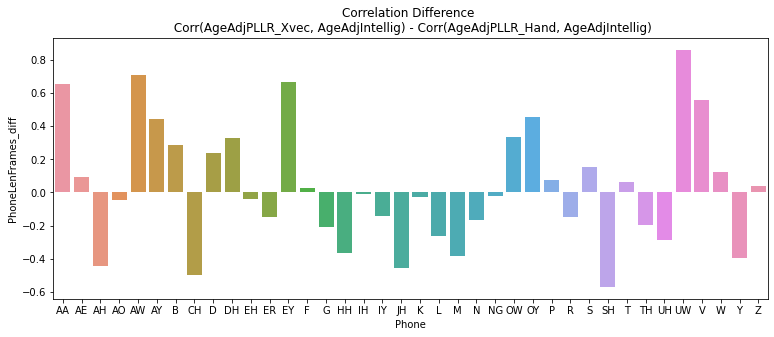

In [47]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='PhoneLenFrames_diff', order=ENGLISH_PHONEME_LIST)
plt.title('Correlation Difference \n Corr(AgeAdjPLLR_Xvec, AgeAdjIntellig) - Corr(AgeAdjPLLR_Hand, AgeAdjIntellig)')

Text(0.5, 1.0, 'Correlation Difference \n Corr(PLLR_Xvec, Age) - Corr(PLLR_Hand, Age)')

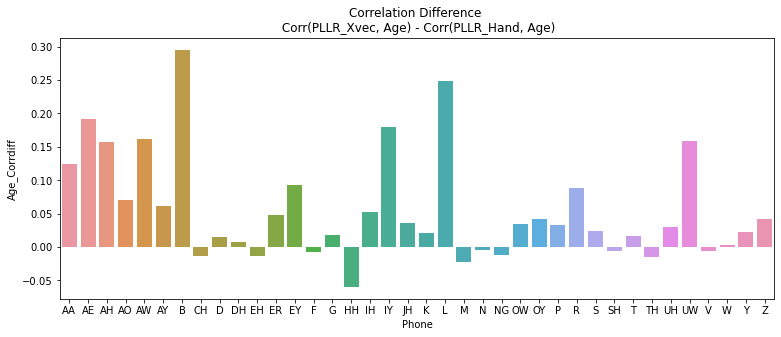

In [34]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='Age_Corrdiff')
plt.title('Correlation Difference \n Corr(PLLR_Xvec, Age) - Corr(PLLR_Hand, Age)')

<AxesSubplot:xlabel='Phone', ylabel='PLLR_xvec_intel_Corr'>

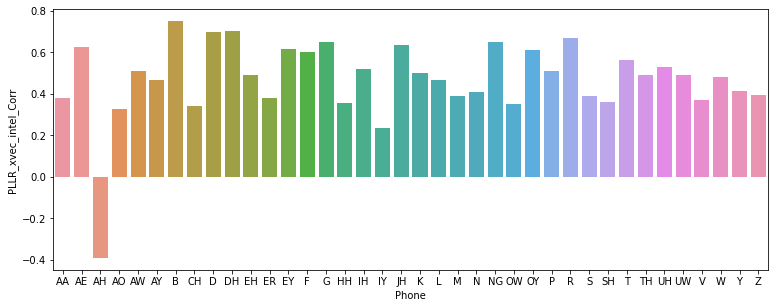

In [35]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='PLLR_xvec_intel_Corr')

<AxesSubplot:xlabel='Age_Corrdiff', ylabel='Intellig_Corrdiff'>

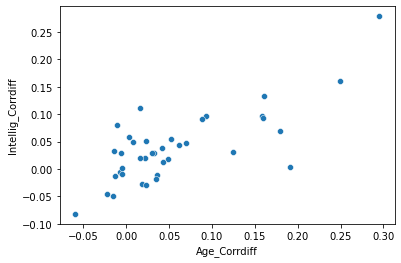

In [36]:
sns.scatterplot(tmp, x='Age_Corrdiff', y='Intellig_Corrdiff')

<AxesSubplot:xlabel='Phone', ylabel='PLLR_diff'>

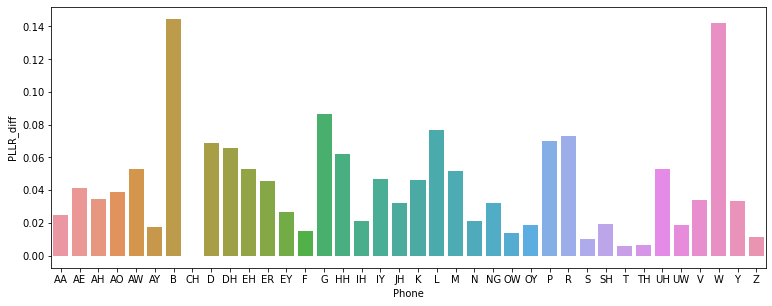

In [42]:
plt.figure(figsize=(6.4*2, 4.8))
sns.barplot(tmp, x='Phone', y='PLLR_diff')

<AxesSubplot:xlabel='age_months', ylabel='PLLR_diff'>

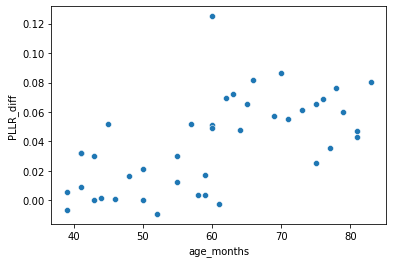

In [42]:
sns.scatterplot(dfm, x='age_months', y='PLLR_diff')

<AxesSubplot:xlabel='mean_intelligibility', ylabel='PLLR_diff'>

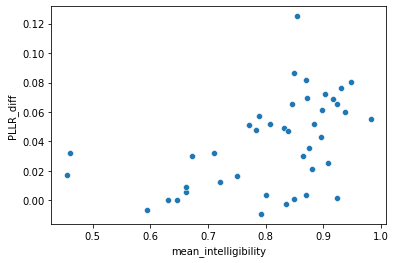

In [43]:
sns.scatterplot(dfm, x='mean_intelligibility', y='PLLR_diff')

<AxesSubplot:xlabel='PhoneLenFrames_hand', ylabel='PLLR_diff'>

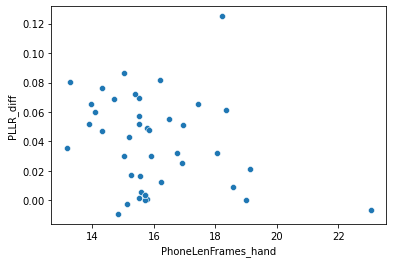

In [46]:
sns.scatterplot(dfm, x='PhoneLenFrames_hand', y='PLLR_diff')

In [45]:
dfm.corr()['age_months']

PLLR_hand                       0.669590
LLP_hand                        0.738660
PhoneLenFrames_hand            -0.505755
PLLR_xvec                       0.735552
LLP_xvec                        0.771273
PhoneLenFrames_xvec            -0.514742
PLLR_diff                       0.599306
age_months                      1.000000
n_items                         0.687923
mean_intelligibility            0.652739
age_adjusted_intelligibility   -0.040011
Name: age_months, dtype: float64

In [ ]:
dfm.corr()['age_months']

In [86]:
import pandas as pd

# Sample DataFrame
data = {'Speaker': ['A', 'B', 'A', 'B'],
        'Value': [10, 20, 30, 40]}
df = pd.DataFrame(data)

# Define a custom aggregation function
def custom_agg_func(group):
    # Example custom aggregation function (you can replace this with your own logic)
    return pd.Series({'Mean_Value': group['Value'].mean(), 'Sum_Value': group['Value'].sum()})

# Group by 'Speaker' and apply the custom aggregation function
result_df = df.groupby('Speaker').apply(custom_agg_func).reset_index()

print(result_df)

  Speaker  Mean_Value  Sum_Value
0       A        20.0       40.0
1       B        30.0       60.0


In [ ]:

intelig_df = 
pd.DataFrame(columns=xdf.columns)


for speaker, _df in 

# Utterance-wise Analysis

In [42]:
xdfu = xdfp.groupby('Utterance').mean()
hdfu = hdfp.groupby('Utterance').mean()

diffdfu = xdfu - hdfu

diffdfu = diffdfu.reset_index()
xdfu = xdfu.reset_index()
hdfu = hdfu.reset_index()


In [43]:
sortedu = diffdfu.sort_values('PLLR', ascending=True).reset_index()

KeyError: 'PLLR'

In [44]:
utt = sortedu.iloc[-20]['Utterance']
hatgpath = f'/home/prad/github/DNN-PLLR/manual_textgrids_postprocessed/0611_F_AP/{utt}.TextGrid'
xvtgpath = f'/home/prad/github/DNN-PLLR/phone_matched_xvec_proj_processed/0611_F_AP/{utt}.TextGrid'

textgridpath_to_phonedf(hatgpath, phone_key='phones', remove_numbers=True)

NameError: name 'sortedu' is not defined

In [45]:
textgridpath_to_phonedf(xvtgpath, phone_key='phones', remove_numbers=True)

NameError: name 'xvtgpath' is not defined

In [162]:
utt = sortedu.iloc[-10]['Utterance']
hatgpath = f'/home/prad/github/DNN-PLLR/manual_textgrids_postprocessed/{utt[:9]}/{utt}.TextGrid'
xvtgpath = f'/home/prad/github/DNN-PLLR/phone_matched_xvec_proj_processed/{utt[:9]}/{utt}.TextGrid'
print(utt)
textgridpath_to_phonedf(hatgpath, phone_key='phones', remove_numbers=True)

0606_F_NSwT15


,start,end,phone
0,0.301892,0.362050,B
1,0.362050,0.695929,AE
2,0.695929,0.729016,D


In [161]:
textgridpath_to_phonedf(xvtgpath, phone_key='phones', remove_numbers=True)

,start,end,phone
0,0.30,0.33,B
1,0.33,0.58,AE
2,0.58,0.72,D


<AxesSubplot:xlabel='PLLR', ylabel='Count'>

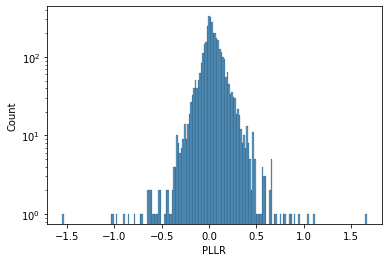

In [122]:
sns.histplot(data=diffdfu, x='PLLR', log=True)

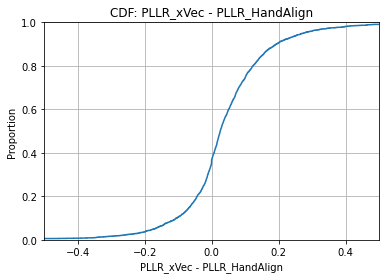

In [132]:
sns.ecdfplot(data=diffdfu, x='PLLR')
plt.xlim()
plt.title('CDF: PLLR_xVec - PLLR_HandAlign')
plt.xlabel('PLLR_xVec - PLLR_HandAlign')
plt.xlim([-.5, .5])
plt.grid(True)

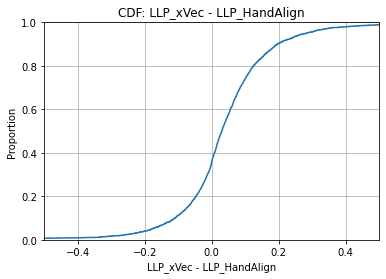

In [133]:
sns.ecdfplot(data=diffdfu, x='LLP')
plt.xlim()
plt.title('CDF: LLP_xVec - LLP_HandAlign')
plt.xlabel('LLP_xVec - LLP_HandAlign')
plt.xlim([-.5, .5])
plt.grid(True)

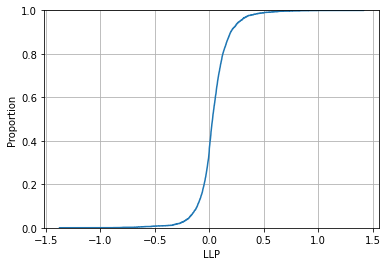

In [127]:
sns.ecdfplot(data=diffdfu, x='LLP')
plt.grid(True)

# Impact of FA results 

In [54]:
# calculate e_on and e_off

for tgfile in tgs_manproc:
    pass
    # print('asdf')

In [55]:
tgs_xv[0]

'/home/prad/github/charsiu/phone_matched_xvec_proj_processed/0407_M_SJ/0407_M_SJwT18.TextGrid'

In [57]:
def calculate_te_for_utterances():
    pass
xvectgs_processed = copy.deepcopy(tgs_xv)
xvectgdir  = '/home/prad/github/charsiu/phone_matched_xvec_proj_processed/'
processed_manual_tgs_dir = '/home/prad/github/DNN-PLLR/manual_textgrids_postprocessed/'
for xvectgpath in xvectgs_processed:
    mantgpath = xvectgpath.replace(xvectgdir, processed_manual_tgs_dir)
    
    
    
    

In [101]:
dflines = []
unks = []
for ii in tqdm.tqdm(range(len(xvectgs_processed))):

    xvectgpath = xvectgs_processed[ii]    
    mantgpath = xvectgpath.replace(xvectgdir, processed_manual_tgs_dir)
    utterance = os.path.basename(xvectgpath).split('.')[0]    
    xvtg = textgridpath_to_phonedf(xvectgpath, phone_key='phones', remove_numbers=True)
    xvtg = xvtg[xvtg.phone!='[SIL]'].reset_index().drop(columns='index')
    mantg = textgridpath_to_phonedf(mantgpath, phone_key='phones', remove_numbers=True)
    # print(xvtg)
    # print(mantg)
    # xvtg = xvtg.drop(columns='index')
    # print(utterance)
    if len(xvtg)!=len(mantg) or '[UNK]' in xvtg.phone.values:
        mismatched.append(ii)
        print(f'WARNING, MISMATCH FOR {utterance}, SKIPPING')
    
    # if ii>10:
        # break
    elif not all(xvtg.phone.values==mantg.phone.values):
        print(f'------WARNING PHONE MISMATCH FOR {utterance}')
        mismatched.append(ii)
    
    else:
        for unique_phn in np.unique(xvtg.phone):
            # print(xvtg)
            # print(mantg)
            xphn = xvtg[xvtg.phone==unique_phn].values[:]
            mphn = mantg[mantg.phone==unique_phn].values
            
            phnlen = np.abs(mphn[:, 0] - mphn[:, 1])
            err_on = np.abs(xphn[:, 0] - mphn[:, 0])
            err_off = np.abs(xphn[:, 1] - mphn[:, 1])
            
            err_on_pct = 100 * (err_on)/phnlen
            err_off_pct = 100 * (err_off)/phnlen
            t_e = np.mean(err_on + err_off)/2
            t_e_pct = np.mean(err_on_pct - err_off_pct)/2
            # tonpct = np.abs(xphn[:, 0] - mphn[:, 0])
            # t_e = 
            # toffpct = np.abs(xphn[:, 0] - )
            # te_pct = np.mean()
            # print('---')
            # print(xphn)
            # print(mphn)
            # print(err_on)
            # print(err_off)
            # print(phnlen)
            # print(err_on_pct)
            # print(err_off_pct)
            # mphn = np.abs(mphn[:, 0] - mphn[:, 1]).mean()
            _line = (err_on.mean(), err_off.mean(), err_on_pct.mean(), err_off_pct.mean(), t_e, t_e_pct, unique_phn, utterance)
            dflines.append(_line)
            
        # break
    # break



 11%|█████████████████                                                                                                                                          | 415/3762 [00:02<00:25, 133.43it/s]

WARNING, MISMATCH FOR 0409_F_LEs7T08, SKIPPING


 20%|███████████████████████████████▍                                                                                                                           | 764/3762 [00:05<00:20, 147.14it/s]

WARNING, MISMATCH FOR 0402_M_ONs7T06, SKIPPING
WARNING, MISMATCH FOR 0402_M_ONs7T01, SKIPPING


 26%|███████████████████████████████████████▋                                                                                                                   | 964/3762 [00:06<00:17, 157.56it/s]

WARNING, MISMATCH FOR 0504_F_ECs4T05, SKIPPING


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                          | 1952/3762 [00:13<00:12, 148.99it/s]

------WARNING PHONE MISMATCH FOR 0400_F_AJs6T09


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3762/3762 [00:25<00:00, 147.33it/s]


In [104]:
te_df = pd.DataFrame(dflines, columns=['e_on', 'e_off', 'e_on_pct', 'e_off_pct', 't_e', 't_e_pct', 'Phone', 'Utterance'])
vdf = mdfp.merge(te_df, on=['Utterance', 'Phone'])

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lm = LinearRegression()

def calc_model1(group, colname='t_e'):
    pllr_hand = group['PLLR_hand'].values
    t_e = group[colname].values
    pllr_xvec = group['PLLR_xvec'].values
    X = copy.deepcopy(t_e).reshape(-1, 1)
    y_true=pllr_xvec

    keepinds = np.logical_and(~np.isnan(pllr_hand), ~np.isnan(pllr_xvec))
    X = X[keepinds]
    y_true = y_true[keepinds]
    lm.fit(X, y_true)
    yhat = lm.predict(X)
    return r2_score(y_true, yhat)

In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lm = LinearRegression()

def calc_model2(group, colname='t_e'):
    pllr_hand = group['PLLR_hand'].values
    t_e = group[colname].values
    pllr_xvec = group['PLLR_xvec'].values
    # X = np.vstack((t_e, pllr_xvec)).T
    X = copy.deepcopy(pllr_hand).reshape(-1, 1)
    y_true=pllr_xvec 

    keepinds = np.logical_and(~np.isnan(pllr_hand), ~np.isnan(pllr_xvec))
    X = X[keepinds, :]
    y_true = y_true[keepinds]
    lm.fit(X, y_true)
    yhat = lm.predict(X)
    return r2_score(y_true, yhat)

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lm = LinearRegression()

def calc_model3(group, colname='t_e'):
    pllr_hand = group['PLLR_hand'].values
    t_e = group[colname].values
    pllr_xvec = group['PLLR_xvec'].values
    X = np.vstack((t_e, pllr_hand)).T
    # X = np.copy.deepcopy(t_e).reshape(-1, 1)
    y_true=pllr_xvec

    keepinds = np.logical_and(~np.isnan(pllr_hand), ~np.isnan(pllr_xvec))
    X = X[keepinds, :]
    y_true = y_true[keepinds]
    lm.fit(X, y_true)
    yhat = lm.predict(X)
    return r2_score(y_true, yhat)

In [109]:
print('===============================================================')
print(f'==================== ALL PHONEMES =====================================')
print('--------------------------')
print('MODEL 1')    
print('--------------------------')    
m1 = calc_model1(vdf)
print(m1)

print('--------------------------')
print('MODEL 2')   
print('--------------------------')    
m2 = calc_model2(vdf)
print(m2)          

print('--------------------------')
print('MODEL 3' )   
print('--------------------------')    
m3 = calc_model3(vdf)
print(m3)          

==================== ALL PHONEMES =====================================
--------------------------
MODEL 1
--------------------------
0.003677229421435224
--------------------------
MODEL 2
--------------------------
0.8881653390377561
--------------------------
MODEL 3
--------------------------
0.8882517034573577


In [110]:
results = []
for _type, group in vdf.groupby('type', as_index=False):
    print('===============================================================')
    print(f'===================={_type}=====================================')
    print(f'====================Fraction:{len(group)/len(vdf):.3f}=====================================')
    print('--------------------------')
    print('MODEL 1')    
    print('--------------------------')    
    m1 = calc_model1(group)
    print(m1)
          
    print('--------------------------')
    print('MODEL 2')   
    print('--------------------------')    
    m2 = calc_model2(group)
    print(m2)          
          
    print('--------------------------')
    print('MODEL 3' )   
    print('--------------------------')    
    m3 = calc_model3(group)
    print(m3)          
    
    results.append((_type, m1, m2, m3))
    

====================affricate=====================================
====================Fraction:0.015=====================================
--------------------------
MODEL 1
--------------------------
0.062252724638191426
--------------------------
MODEL 2
--------------------------
0.9291483646607269
--------------------------
MODEL 3
--------------------------
0.9293668365259123
====================fricative=====================================
====================Fraction:0.201=====================================
--------------------------
MODEL 1
--------------------------
0.003228467815871494
--------------------------
MODEL 2
--------------------------
0.8869020925598697
--------------------------
MODEL 3
--------------------------
0.8869070511401235
====================glide=====================================
====================Fraction:0.018=====================================
--------------------------
MODEL 1
--------------------------
0.007999509526773307
--------------

In [111]:
print('===============================================================')
print(f'==================== ALL PHONEMES =====================================')
print('--------------------------')
print('MODEL 1')    
print('--------------------------')    
m1 = calc_model1(vdf, colname='t_e_pct')
print(m1)

print('--------------------------')
print('MODEL 2')   
print('--------------------------')    
m2 = calc_model2(vdf, colname='t_e_pct')
print(m2)          

print('--------------------------')
print('MODEL 3' )   
print('--------------------------')    
m3 = calc_model3(vdf, colname='t_e_pct')
print(m3)          


results = []
for _type, group in vdf.groupby('type', as_index=False):
    print('===============================================================')
    print(f'===================={_type}=====================================')
    print(f'====================Fraction:{len(group)/len(vdf):.3f}=====================================')
    print('--------------------------')
    print('MODEL 1')    
    print('--------------------------')    
    m1 = calc_model1(group, colname='t_e_pct')
    print(m1)
          
    print('--------------------------')
    print('MODEL 2')   
    print('--------------------------')    
    m2 = calc_model2(group, colname='t_e_pct')
    print(m2)          
          
    print('--------------------------')
    print('MODEL 3' )   
    print('--------------------------')    
    m3 = calc_model3(group, colname='t_e_pct')
    print(m3)          
    
    results.append((_type, m1, m2, m3))
    

==================== ALL PHONEMES =====================================
--------------------------
MODEL 1
--------------------------
0.00020784317717736922
--------------------------
MODEL 2
--------------------------
0.8881653390377561
--------------------------
MODEL 3
--------------------------
0.8881824751058534
====================affricate=====================================
====================Fraction:0.015=====================================
--------------------------
MODEL 1
--------------------------
0.00018323665179742488
--------------------------
MODEL 2
--------------------------
0.9291483646607269
--------------------------
MODEL 3
--------------------------
0.929181910813086
====================fricative=====================================
====================Fraction:0.201=====================================
--------------------------
MODEL 1
--------------------------
0.0013945873536992393
--------------------------
MODEL 2
--------------------------
0.886902092

In [117]:
vdf.sort_values('PLLR_diff').dropna()

,Speaker,Utterance,Phone,PLLR_hand,LLP_hand,PhoneLenFrames_hand,PLLR_xvec,LLP_xvec,PhoneLenFrames_xvec,PLLR_diff,...,age_months,n_items,mean_intelligibility,age_adjusted_intelligibility,e_on,e_off,e_on_pct,e_off_pct,t_e,t_e_pct
21370,0402_F_KP,0402_F_KPs3T01,Z,-1.683165,-3.889998,19,-4.112974,-5.583079,5,-2.429809,...,50,78,0.645513,-0.094595,0.053101,0.198374,27.193298,101.588117,0.125738,-37.197410
26593,0308_F_AGL,0308_F_AGLs4T09,L,-0.204757,-1.024762,5,-2.542754,-3.104012,14,-2.337997,...,44,98,0.923919,0.221713,0.020000,0.060341,33.524045,101.144273,0.040171,-33.810114
13031,0411_F_AW,0411_F_AWs2T09,G,-0.718278,-1.725657,6,-3.013431,-3.837018,16,-2.295153,...,59,98,0.870032,0.073072,0.011630,0.080000,19.925642,137.057877,0.045815,-58.566117
2407,0500_M_QA,0500_M_QAs5T04,B,-0.891953,-1.897228,9,-3.181772,-4.731601,60,-2.289819,...,60,93,0.770533,-0.032744,0.013233,0.523148,14.689113,580.729271,0.268190,-283.020079
19709,0601_M_JL,0601_M_JLcs7T08,NG,-0.999466,-2.714949,9,-3.192461,-4.582340,19,-2.192995,...,73,93,0.897824,0.012429,0.010000,0.078745,10.958327,86.291552,0.044373,-37.666612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15417,0509_F_ES,0509_F_ESs7T02,S,-4.022707,-4.928313,3,-1.140188,-2.154617,15,2.882520,...,69,96,0.788542,-0.071586,0.130000,0.011468,413.114343,36.443947,0.070734,188.335198
9721,0500_M_WD,0500_M_WDs7T10,W,-3.305373,-4.748305,21,-0.324298,-2.768118,9,2.981075,...,60,97,0.831376,0.028100,0.045118,0.174166,21.582616,83.313887,0.109642,-30.865635
1822,0503_M_SR,0503_M_SRs4T02,HH,-3.159111,-4.046335,4,-0.091852,-0.705016,7,3.067259,...,63,98,0.902940,0.080713,0.091553,0.062205,225.209883,153.018136,0.076879,36.095873
16609,0603_M_LS,0603_M_LSs5T06,EH,-4.286394,-4.961349,4,-0.790406,-2.152699,8,3.495989,...,75,98,0.924526,0.026497,0.067024,0.020000,155.956549,46.537554,0.043512,54.709497


0.8017862551025204
0.03715945799154755
0.3472372887286979


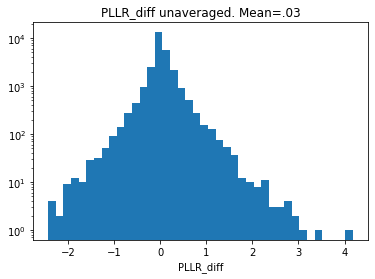

In [147]:
plt.hist(vdf['PLLR_diff'], log=True, bins=40)
plt.title('PLLR_diff unaveraged. Mean=.03')
plt.xlabel('PLLR_diff')
print(pd.DataFrame.skew(vdf['PLLR_diff']))
print(vdf['PLLR_diff'].mean())
print(sum(vdf['PLLR_diff']<0)/len(vdf))

0.12886381217663265
0.3521426670215598


Text(0.5, 0, 'PLLR_diff')

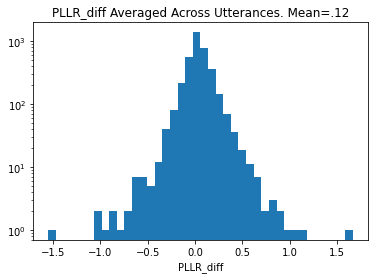

In [152]:
_pllrdiff = vdf.groupby('Utterance').mean()['PLLR_xvec'] - vdf.groupby('Utterance').mean()['PLLR_hand']
plt.hist(_pllrdiff, bins=40, log=True)
print(pd.DataFrame.skew(_pllrdiff ))
print(sum(_pllrdiff<0)/len(_pllrdiff ))
plt.title('PLLR_diff Averaged Across Utterances. Mean=.12')
plt.xlabel('PLLR_diff')

0.5121188497408116
0.09523809523809523
0.035370952415459005


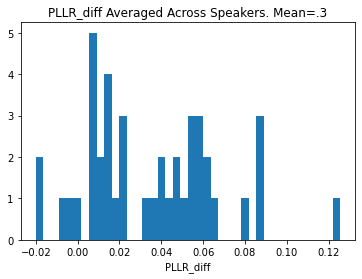

In [150]:
_pllrdiff = vdf.groupby(['Utterance', 'Speaker']).mean().groupby('Speaker').mean()['PLLR_xvec'] - vdf.groupby(['Utterance', 'Speaker']).mean().groupby('Speaker').mean()['PLLR_hand']
plt.hist(_pllrdiff, bins=40, log=False)
print(pd.DataFrame.skew(_pllrdiff ))
print(sum(_pllrdiff<0)/len(_pllrdiff ))
plt.title('PLLR_diff Averaged Across Speakers. Mean=.03')
plt.xlabel('PLLR_diff')
print(np.mean(_pllrdiff))


In [ ]:
plt.hist(vdf.groupby('Utt'), log=True, bins=40)
plt.title('PLLR_diff unaveraged')
plt.xlabel('PLLR_diff')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lm = LinearRegression()

# def calc_model1(group):
group=vdf.copy()
pllr_hand = group['PLLR_hand'].values
t_e = group['t_e'].values
pllr_xvec = group['PLLR_xvec'].values
X = np.vstack((t_e, pllr_xvec)).T
# X = np.copy.deepcopy(t_e).reshape(-1, 1)
y_true=pllr_hand

keepinds = np.logical_and(~np.isnan(pllr_hand), ~np.isnan(pllr_xvec))
X = X[keepinds, :]
y_true = y_true[keepinds]
lm.fit(X, y_true)
yhat = lm.predict(X)
r2_score(y_true, yhat)

In [274]:
''' model1'''

beta = np.array([1, -.1])
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                     nan
Model:                            OLS   Adj. R-squared (uncentered):                nan
Method:                 Least Squares   F-statistic:                                nan
Date:                Fri, 17 Nov 2023   Prob (F-statistic):                         nan
Time:                        01:46:56   Log-Likelihood:                             nan
No. Observations:               28577   AIC:                                        nan
Df Residuals:                   28576   BIC:                                        nan
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
'''model2'''


In [ ]:
'''model3'''


In [266]:
mdfp.columns

Index(['Speaker', 'Utterance', 'Phone', 'PLLR_hand', 'LLP_hand',
       'PhoneLenFrames_hand', 'PLLR_xvec', 'LLP_xvec', 'PhoneLenFrames_xvec',
       'PLLR_diff', 'type', 'age_months', 'n_items', 'mean_intelligibility',
       'age_adjusted_intelligibility'],
      dtype='object')

In [ ]:
mdfp['PLLR_hand']

In [350]:
# idx = mismatched[-3]
xvectgpath = [tgpth for tgpth in xvectgs_processed if '0606_F_NSwT15' in tgpth]
xvectgpath = xvectgpath[0]
mantgpath = xvectgpath.replace(xvectgdir, processed_manual_tgs_dir)

xvtg = textgridpath_to_phonedf(xvectgpath, phone_key='phones', remove_numbers=True)
xvtg = xvtg[xvtg.phone!='[SIL]'].reset_index()

mantg = textgridpath_to_phonedf(mantgpath, phone_key='phones', remove_numbers=True)

In [351]:
xvtg

,index,start,end,phone
0,1,0.30,0.33,B
1,2,0.33,0.58,AE
2,3,0.58,0.72,D


In [352]:
mantg

,start,end,phone
0,0.301892,0.362050,B
1,0.362050,0.695929,AE
2,0.695929,0.729016,D


In [248]:
len(xvtg)!=len(mantg)

True

In [ ]:
def get_concat_df(phonewise_df_dnn, phonewise_df_xvec):
    pass

In [ ]:
def compute_model1(phonewise_df):
    x = phonewise_df['t_e']
    y = phonewise_df['']
    